In [1]:
# https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb
# https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Hyperparameters

NOISE = 0.2     # amount of noise to add to exercise 0.2
NETWORK = 'ANN'    # or ANN
THRESHOLD = 3      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.06 # threshold for deterministic 0.05 and for min and max : 0.03

In [4]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [5]:
#path = './data/Zero_Day/'
path ='F:/JD_Zero_Attack/Zero_Day/Zero_Day/'
path_normal = path +'normal.csv'
#path_normal = path +'VAE_syntheticdata_normal_epoch50_100000.csv'
path_combine = path +'VAE_syntheticdata_combine_epoch10_2000000.csv'
#path_attack = path +'VAE_syntheticdata_attack_epoch100_1000000.csv'
path_attack = path + 'attack.csv'

normal_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
normal_df['marker'] = normal_df.apply(label_marker, axis=1)
attack_df['marker'] = attack_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
normal_label = normal_df['marker'].to_numpy() 
attack_label = attack_df['marker'].to_numpy() 
print(len(combine_labels))
print(len(normal_label))
print(len(attack_label))

1571591
22714
55663


In [6]:
# Delete marker column 
normal_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)

normal shape (22714, 128)
attack shape (55663, 128)
combine shape (1571591, 128)


In [8]:
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(combine_df)

In [9]:
df_scaled.shape

(1571591, 128)

In [10]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

In [11]:
attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [12]:
normal_scaled.shape

(22714, 128)

In [13]:
attack_scaled.shape

(55663, 128)

In [14]:
labels = combine_labels
norm_samples = df_scaled[labels == 0]  # normal data
attack_samples = df_scaled[labels == 1]  # attack data

norm_labels = labels[labels == 0]
attack_labels = labels[labels == 1]

In [15]:
attack_samples.shape
norm_samples.shape

(735798, 128)

In [16]:
# generate train set
# training set will consist of the normal ds

len_norm = len(normal_scaled)
len_norm_train = int(0.80 * len_norm)
X_train = normal_scaled[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = normal_scaled[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
#X_test = X_test_norm
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [17]:
X_train.shape

(18171, 128)

In [18]:
X_test.shape

(9086, 128)

In [19]:
y_test.shape

(9086,)

In [20]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [21]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [22]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
#intermediate_dim = 512
#latent_dim = 256

In [23]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 42)           2730        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 42)           2730        ['dense[0][0]']                  
                                                                                            

In [24]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 42)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                2752      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
Total params: 11,072
Trainable params: 11,072
Non-trainable params: 0
_________________________________________________________________


In [25]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [26]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [27]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=1000,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128)]             0         
                                                                 
 encoder (Functional)        (None, 42)                13716     
                                                                 
 decoder (Functional)        (None, 128)               11072     
                                                                 
Total params: 24,788
Trainable params: 24,788
Non-trainable params: 0
_________________________________________________________________
Train on 18171 samples
Epoch 1/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 258.4377
Epoch 2/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 87.8720
Epoch 3/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 67.6722
Epoch 4/1000
18171/181

18171/18171 [==============================] - 1s 31us/sample - loss: 18.8381
Epoch 82/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 18.8193
Epoch 83/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 18.7553
Epoch 84/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 18.6925
Epoch 85/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 18.6565
Epoch 86/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 18.5999
Epoch 87/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 18.5337
Epoch 88/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 18.4260
Epoch 89/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 18.4268
Epoch 90/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 18.3653
Epoch 91/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 18.3501
Ep

18171/18171 [==============================] - 1s 32us/sample - loss: 15.9780
Epoch 170/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 15.8854
Epoch 171/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 15.8588
Epoch 172/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 15.8745
Epoch 173/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 15.8453
Epoch 174/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 15.8196
Epoch 175/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 15.8010
Epoch 176/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 15.7699
Epoch 177/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 15.7726
Epoch 178/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 15.7512
Epoch 179/1000
18171/18171 [==============================] - 1s 31us/sample - loss: 

18171/18171 [==============================] - 1s 35us/sample - loss: 14.6991
Epoch 258/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.6789
Epoch 259/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.6960
Epoch 260/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.7303
Epoch 261/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.6766
Epoch 262/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.6484
Epoch 263/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.6457
Epoch 264/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.6864
Epoch 265/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.6839
Epoch 266/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.6149
Epoch 267/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 

18171/18171 [==============================] - 1s 33us/sample - loss: 14.1731
Epoch 346/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.1938
Epoch 347/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.1552
Epoch 348/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.1731
Epoch 349/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 14.2067
Epoch 350/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.1499
Epoch 351/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.1291
Epoch 352/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.1694
Epoch 353/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 14.1680
Epoch 354/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 14.1072
Epoch 355/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 

18171/18171 [==============================] - 1s 32us/sample - loss: 13.8441
Epoch 434/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.8192
Epoch 435/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 13.7924
Epoch 436/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.8721
Epoch 437/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.7743
Epoch 438/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 13.7859
Epoch 439/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.8157
Epoch 440/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 13.8101
Epoch 441/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.8336
Epoch 442/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.7794
Epoch 443/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 

18171/18171 [==============================] - 1s 32us/sample - loss: 13.7015
Epoch 522/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.6314
Epoch 523/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.6726
Epoch 524/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.6456
Epoch 525/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.6275
Epoch 526/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.6361
Epoch 527/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.6195
Epoch 528/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.6921
Epoch 529/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 13.6341
Epoch 530/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.5936
Epoch 531/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 

18171/18171 [==============================] - 1s 34us/sample - loss: 13.4420
Epoch 610/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 13.4176
Epoch 611/1000
18171/18171 [==============================] - 1s 42us/sample - loss: 13.4632
Epoch 612/1000
18171/18171 [==============================] - 1s 42us/sample - loss: 13.4602
Epoch 613/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 13.4188
Epoch 614/1000
18171/18171 [==============================] - 1s 42us/sample - loss: 13.3591
Epoch 615/1000
18171/18171 [==============================] - 1s 37us/sample - loss: 13.4306
Epoch 616/1000
18171/18171 [==============================] - 1s 39us/sample - loss: 13.4250
Epoch 617/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.4274
Epoch 618/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.4312
Epoch 619/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 

18171/18171 [==============================] - 1s 32us/sample - loss: 13.4432
Epoch 698/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.3513
Epoch 699/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.3251
Epoch 700/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 13.3359
Epoch 701/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.3476
Epoch 702/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2843
Epoch 703/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.3683
Epoch 704/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.3880
Epoch 705/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 13.3554
Epoch 706/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.3057
Epoch 707/1000
18171/18171 [==============================] - 1s 32us/sample - loss: 

18171/18171 [==============================] - 1s 33us/sample - loss: 13.2606
Epoch 786/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.3302
Epoch 787/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2542
Epoch 788/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2875
Epoch 789/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2844
Epoch 790/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2665
Epoch 791/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2736
Epoch 792/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2878
Epoch 793/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2754
Epoch 794/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.3190
Epoch 795/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 

18171/18171 [==============================] - 1s 33us/sample - loss: 13.2001
Epoch 874/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2162
Epoch 875/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2435
Epoch 876/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2378
Epoch 877/1000
18171/18171 [==============================] - 1s 36us/sample - loss: 13.1938
Epoch 878/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2012
Epoch 879/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2308
Epoch 880/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2403
Epoch 881/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2187
Epoch 882/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2259
Epoch 883/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 

18171/18171 [==============================] - 1s 35us/sample - loss: 13.2850
Epoch 962/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2161
Epoch 963/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2522
Epoch 964/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.3129
Epoch 965/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2344
Epoch 966/1000
18171/18171 [==============================] - 1s 33us/sample - loss: 13.2235
Epoch 967/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.1980
Epoch 968/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2781
Epoch 969/1000
18171/18171 [==============================] - 1s 34us/sample - loss: 13.2441
Epoch 970/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 13.2428
Epoch 971/1000
18171/18171 [==============================] - 1s 35us/sample - loss: 

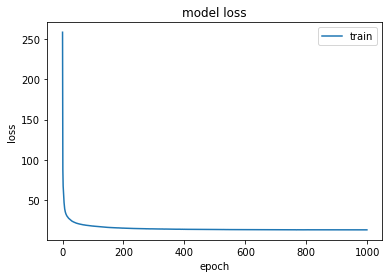

In [28]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [29]:
X_train_pred = vae_model.predict(X_train)

C:\Users\darsh\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [30]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.98)
print(error_thresh)

Avg error 0.019244123720643647
median error 0.016474715844454105
99Q: 0.07083841606606395
setting threshold on 0.07083841606606395 
0.05527577769053701


In [31]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 9086
4677
total y_test 9086
4543


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      4543
         1.0       0.97      1.00      0.99      4543

    accuracy                           0.99      9086
   macro avg       0.99      0.99      0.99      9086
weighted avg       0.99      0.99      0.99      9086



In [33]:
X_pred.shape

(9086, 128)

In [34]:
X_encoded = encoder.predict(X_test)

C:\Users\darsh\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

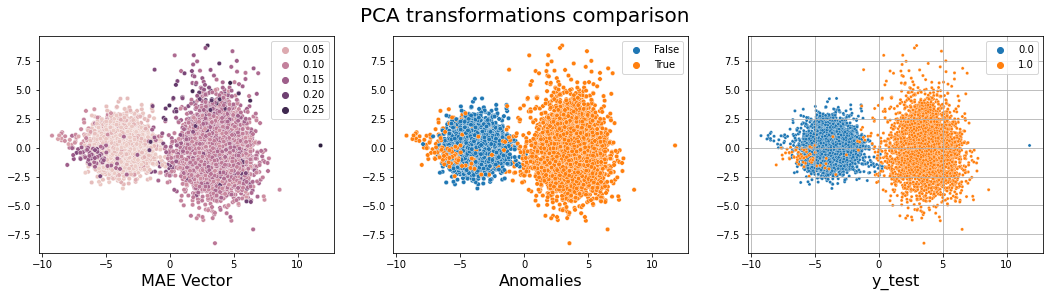

In [36]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.grid()
plt.show()

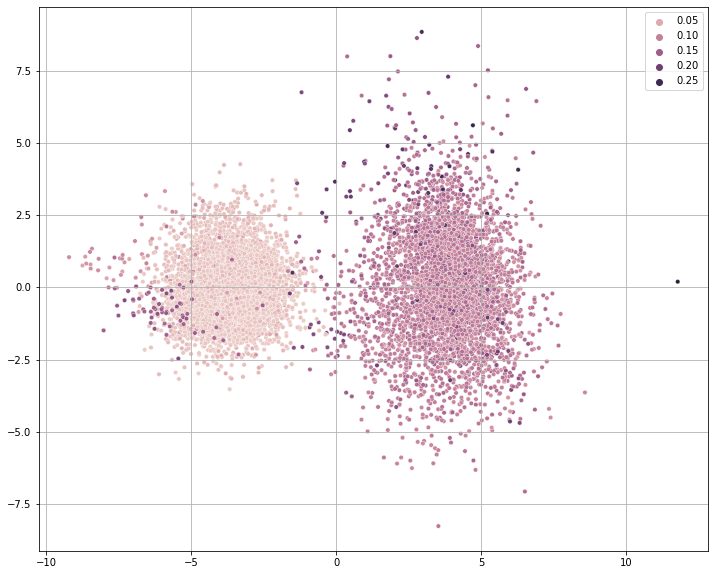

In [37]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

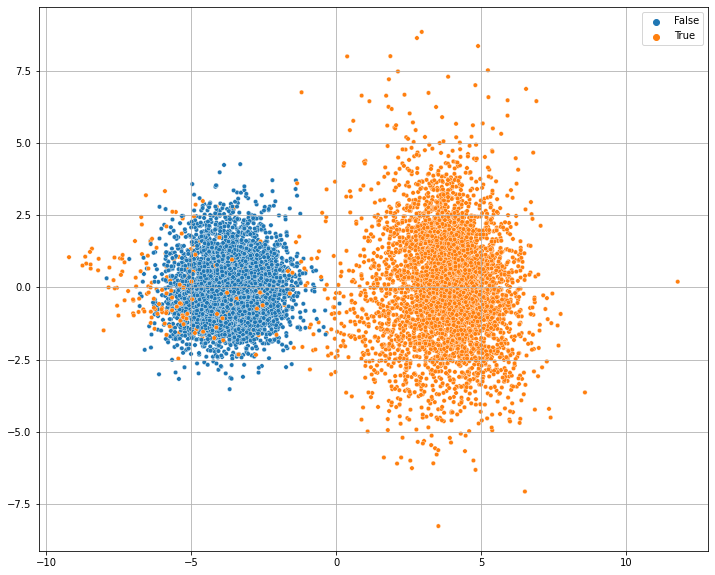

In [38]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

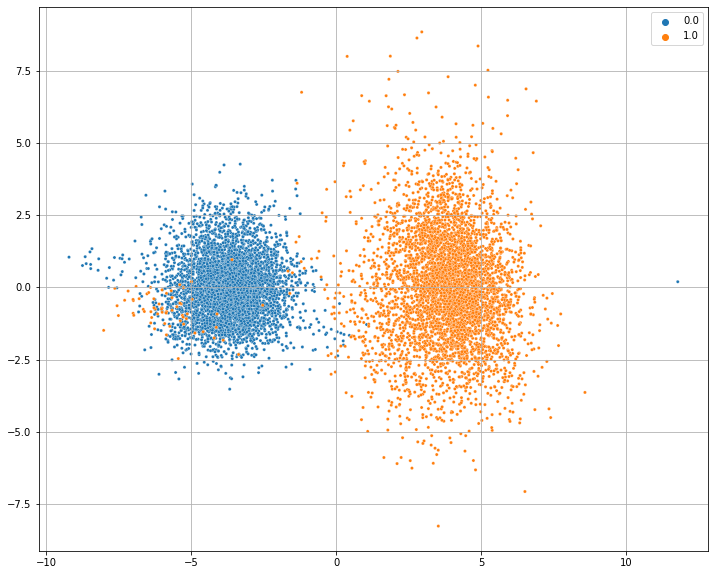

In [39]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [40]:
X_pred.shape

(9086, 128)

0.05527577769053701


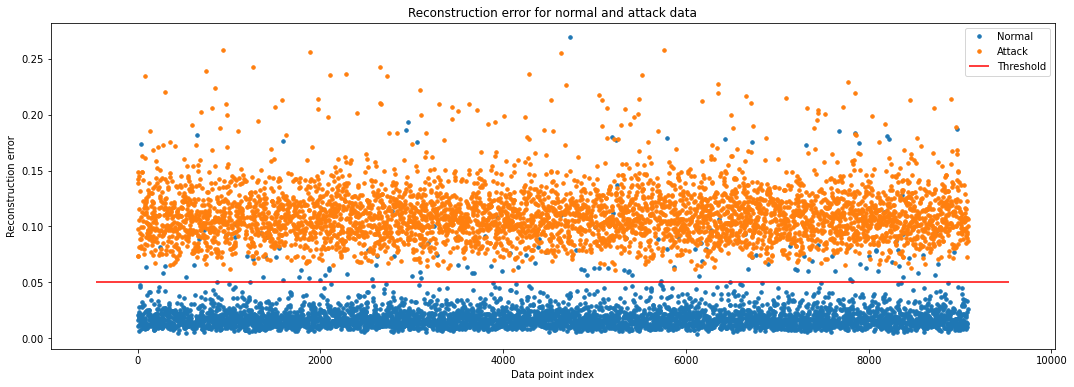

In [41]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = 0.05
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [42]:
lobal_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(Attack_error.shape, Normal_error.shape)

(4543,) (4543,)


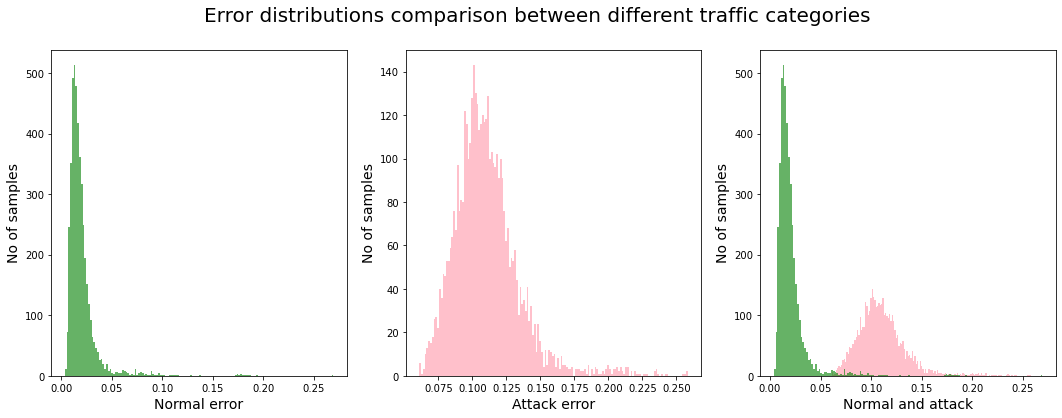

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distributions comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='pink')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='pink')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

### 